In [1]:
import cv2
import numpy as np
import random
import math
from matplotlib import pyplot as plt

random.seed(42)

# set environment variable BEFORE importing cv2
import os
os.environ["OPENCV_VIDEOIO_MSMF_ENABLE_HW_TRANSFORMS"] = "0"
import cv2


cam = cv2.VideoCapture(1) # use 0 if your device has no webcam
ret, img = cam.read()
cam.release() # release the camera

if not ret:
  print("error: couldn't take photo")
  exit(1)

#save image
cv2.imwrite("maze_img0.png", img)

# Or just directly use image object 'img' in your code

# SYSTEM PARAMETERS

You are free to change the value of these variables for testing, but do not add extra variables here. This entire block will be replaced when marking.

In [2]:
# DO NOT ADD OTHER VARIABLES HERE

# General settings
seed = 42
image_file = "raw1.png"

# Task 1 - Occupancy map
threshold_value = 150 # for the occupancy map
autocrop_threshold_value = 145 # for the autocrop adjustment/finetuning
unsafe_kernel_size = 7
unsafe_iterations = 3

# Edge detection parameters
canny_low_threshold = 50
canny_high_threshold = 150
sobel_threshold = 50

# Task 3 - BFS
bfs_n = 10  # Wall grid size (kept for reference)
bfs_start_node = 36  # Start node (0 to 80 for 9x9 grid)
bfs_end_node = 61   # End node (0 to 80 for 9x9 grid)

# Task 4 - PRM and Dijkstra
prm_total_nodes_count = 30
prm_connection_radius = 200
prm_start_node = 20            # Start node using same grid system as BFS (0 to 80 for 9x9 grid)
prm_end_node = 60              # End node using same grid system as BFS (0 to 80 for 9x9 grid)

# Task 5 - RRT
rrt_max_nodes_count = 500
rrt_step_size = 40
rrt_max_connection_length = 200
rrt_start_location = (50,50)
rrt_goal_location = (450,450)

# DO NOT ADD OTHER VARIABLES HERE

# Task 1 - OCCUPANCY MAP (5 marks total)

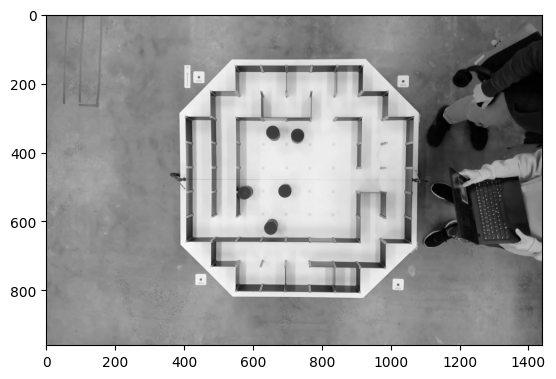

In [3]:
# Task 1.1 (1 mark): Display the occupancy map
image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)

# Display resulting image
plt.imshow(image, cmap = 'gray')
plt.show()


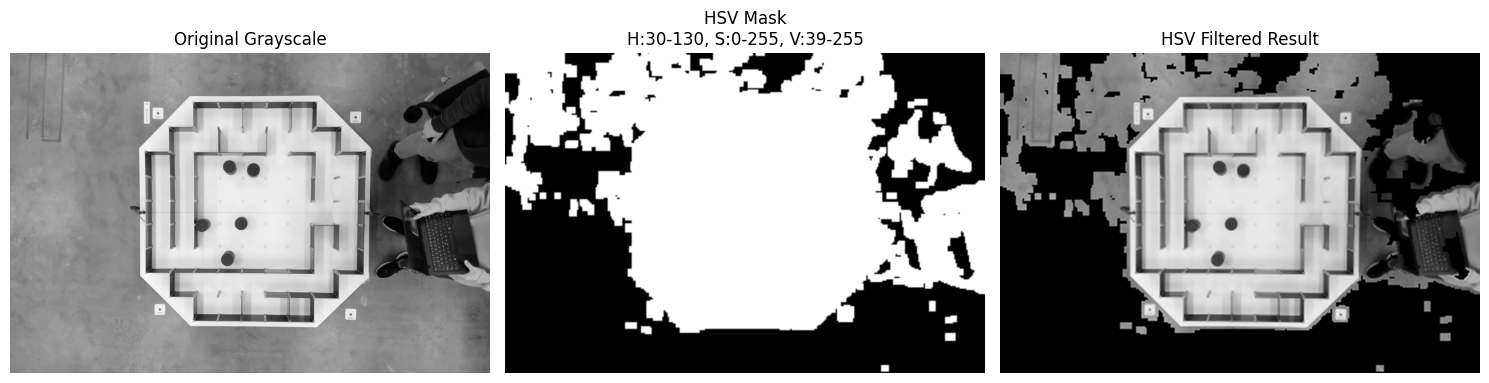

HSV filtering applied with values:
  H: 30-130 (out of 0-179)
  S: 0-255 (out of 0-255)
  V: 39-255 (out of 0-255)
Processed image size: (960, 1440)


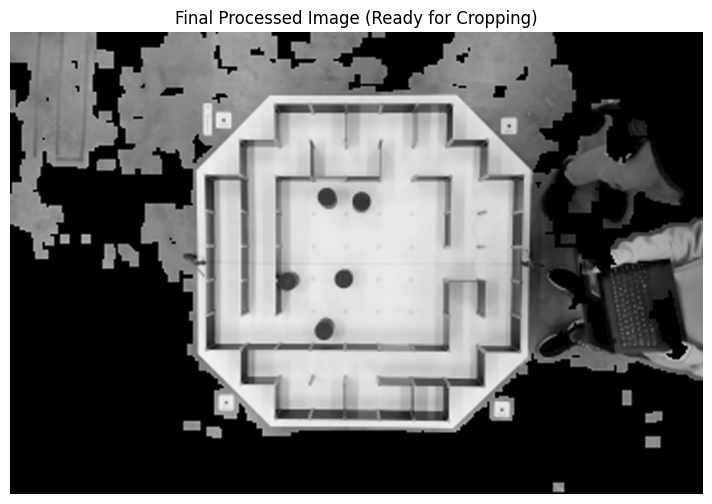

In [4]:
#preprocessing image for autocrop
# HSV Color Filtering with specified values
# Apply HSV filtering to process the image with predetermined values

# Load the image (check if it exists first)
if image is None:
    print("Error: Could not load image. Check if the file exists.")
else:
    # Read source image in color mode for HSV processing
    img_color = cv2.imread(image_file, cv2.IMREAD_COLOR)
    
    if img_color is None:
        print("Error: Could not load color image.")
    else:
        # Scale down the image by a factor of 4 for processing
        width = img_color.shape[1] // 4
        height = img_color.shape[0] // 4
        img_resized = cv2.resize(img_color, (width, height), interpolation=cv2.INTER_AREA)
        
        # Convert source image to HSV color mode
        hsv = cv2.cvtColor(img_resized, cv2.COLOR_BGR2HSV)
        
        # Define HSV range with your specified values
        # H: 49-130, S: 0-255, V: 39-255
        H_low, H_high = 30, 130
        S_low, S_high = 0, 255  
        V_low, V_high = 39, 255
        
        hsv_low = np.array([H_low, S_low, V_low], np.uint8)
        hsv_high = np.array([H_high, S_high, V_high], np.uint8)
        
        # Create mask for the specified HSV range
        mask = cv2.inRange(hsv, hsv_low, hsv_high)
        
        # Apply erosion to remove small noise and stray peppers
        erosion_kernel = np.ones((3,3), np.uint8)
        mask = cv2.dilate(mask, erosion_kernel, iterations=2)
        
        # Apply mask to get filtered result
        res = cv2.bitwise_and(img_resized, img_resized, mask=mask)
        
        # Convert back to grayscale for consistency with rest of notebook
        res_gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
        
        # Update the image variable to use the processed result
        # Scale back up to original size for subsequent processing
        original_height, original_width = image.shape[:2]
        image = cv2.resize(res_gray, (original_width, original_height), interpolation=cv2.INTER_CUBIC)
        
        # Display the results
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Original grayscale
        axes[0].imshow(cv2.imread(image_file, cv2.IMREAD_GRAYSCALE), cmap='gray')
        axes[0].set_title('Original Grayscale')
        axes[0].axis('off')
        
        # Mask
        axes[1].imshow(cv2.resize(mask, (original_width, original_height)), cmap='gray')
        axes[1].set_title(f'HSV Mask\nH:{H_low}-{H_high}, S:{S_low}-{S_high}, V:{V_low}-{V_high}')
        axes[1].axis('off')
        
        # Processed result
        axes[2].imshow(image, cmap='gray')
        axes[2].set_title('HSV Filtered Result')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"HSV filtering applied with values:")
        print(f"  H: {H_low}-{H_high} (out of 0-179)")
        print(f"  S: {S_low}-{S_high} (out of 0-255)")  
        print(f"  V: {V_low}-{V_high} (out of 0-255)")
        print(f"Processed image size: {image.shape}")

# Display the final processed image
plt.figure(figsize=(10, 6))
plt.imshow(image, cmap='gray')
plt.title('Final Processed Image (Ready for Cropping)')
plt.axis('off')
plt.show()




Cropping by largest contour
Detected boundaries - Top: 158, Bottom: 163, Left: 417, Right: 386
Original image size: 1440x960
Cropped image size: 637x639


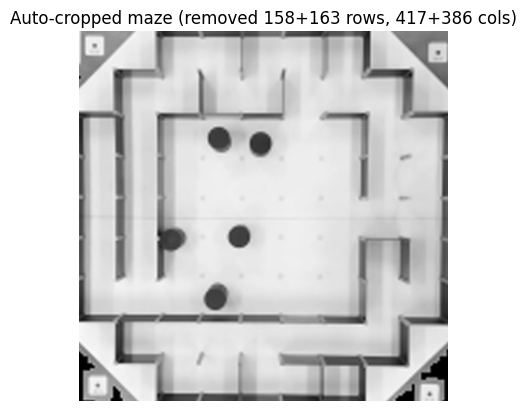

In [5]:
#autocropping

# Improved maze boundary detection using edge detection and contour analysis
def find_maze_boundaries(image, min_line_length=500):
    h, w = image.shape[:2]

    # use EXACTLY the same preprocessing as the visualizer
    _, binary = cv2.threshold(image, autocrop_threshold_value, 255, cv2.THRESH_BINARY)
    kernel = np.ones((5,5), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN,  kernel, iterations=1)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

    cnts = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = cnts[0] if len(cnts) == 2 else cnts[1]   # works on OpenCV 3 & 4

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)

        # bounding rect of the largest contour → use it directly
        x, y, cont_w, cont_h = cv2.boundingRect(largest_contour)
        margin = 10
        top    = max(0, y - margin)
        left   = max(0, x - margin)
        bottom = max(0, h - (y + cont_h) - margin)
        right  = max(0, w - (x + cont_w) - margin)
        print("Cropping by largest contour")
        return top, bottom, left, right

def find_content_boundaries(image):
    """
    Find boundaries based on image content (non-white regions).
    """
    h, w = image.shape[:2]
    
    # Find non-white pixels (assuming white background)
    non_white = image < 240
    
    # Find rows and columns with content
    row_has_content = np.any(non_white, axis=1)
    col_has_content = np.any(non_white, axis=0)
    
    # Find first and last rows/columns with content
    content_rows = np.where(row_has_content)[0]
    content_cols = np.where(col_has_content)[0]
    
    if len(content_rows) > 0 and len(content_cols) > 0:
        margin = 10
        top = max(0, content_rows[0] - margin)
        bottom = max(0, h - content_rows[-1] - margin)
        left = max(0, content_cols[0] - margin)
        right = max(0, w - content_cols[-1] - margin)
        
        print(f"Using content-based detection")
        return top, bottom, left, right
    
    # Ultimate fallback
    print("All methods failed, using minimal cropping")
    return 50, 50, 50, 50

# Detect maze boundaries automatically
top, bottom, left, right = find_maze_boundaries(image, min_line_length=500)

print(f"Detected boundaries - Top: {top}, Bottom: {bottom}, Left: {left}, Right: {right}")

# Apply the detected cropping
h, w = image.shape[:2]
cropped = image[top:h-bottom, left:w-right]

print(f"Original image size: {w}x{h}")
print(f"Cropped image size: {cropped.shape[1]}x{cropped.shape[0]}")

plt.imshow(cropped, cmap='gray' if cropped.ndim == 2 else None)
plt.axis('off')
plt.title(f'Auto-cropped maze (removed {top}+{bottom} rows, {left}+{right} cols)')
plt.show()


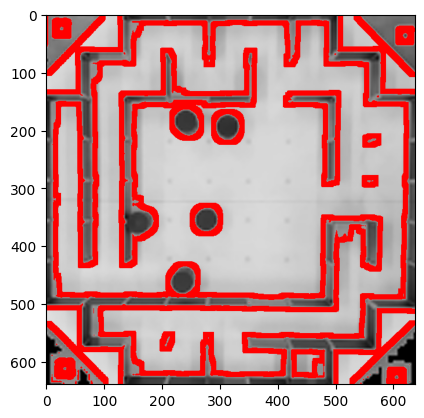

In [6]:
# Task 1.2 (4 Marks): Process occupancy map add and display configuration space
kernel = np.ones((unsafe_kernel_size, unsafe_kernel_size), np.uint8) # TODO: Use this kernenl to generate un_safe area

_, binary_obstacles = cv2.threshold(cropped, threshold_value, 255, cv2.THRESH_BINARY_INV)
expanded_obstacles = cv2.dilate(binary_obstacles, kernel, iterations=unsafe_iterations)
buffer_zone = expanded_obstacles - binary_obstacles


colour_image = cv2.cvtColor(cropped, cv2.COLOR_GRAY2RGB)

colour_image[buffer_zone == 255] = [255, 0, 0]

# Display resulting image
plt.imshow(colour_image)
plt.show()

## Analysis: Using Raw Canny-Only vs Combined Approach

**Benefits of Raw Canny-Only Approach:**
- **Ultra-thin edges**: Raw Canny provides the thinnest possible edge detection without any thickening
- **Maximum navigable space**: Preserves the most space for navigation by not over-expanding obstacles  
- **True edge detection**: Detects only actual boundaries, not filled regions
- **Simple and fast**: No morphological operations needed, just pure edge detection
- **Tunable sensitivity**: Easy to adjust with just two threshold parameters

**Potential Drawbacks:**
- **Very thin obstacles**: Obstacles are represented as 1-pixel wide lines which may be unrealistic
- **Gaps in detection**: Raw edges may have breaks that could create false passages
- **No noise reduction**: Without morphological cleaning, may include noise edges

**Comparison Results:**
- Green areas: Features detected only by raw Canny (pure edge boundaries)
- Red areas: Features detected only by thresholding (filled regions)  
- Blue areas: Features detected by both methods (boundary overlaps)

The raw Canny-only approach works best when you want maximum navigable space and the maze has well-defined, continuous edges.


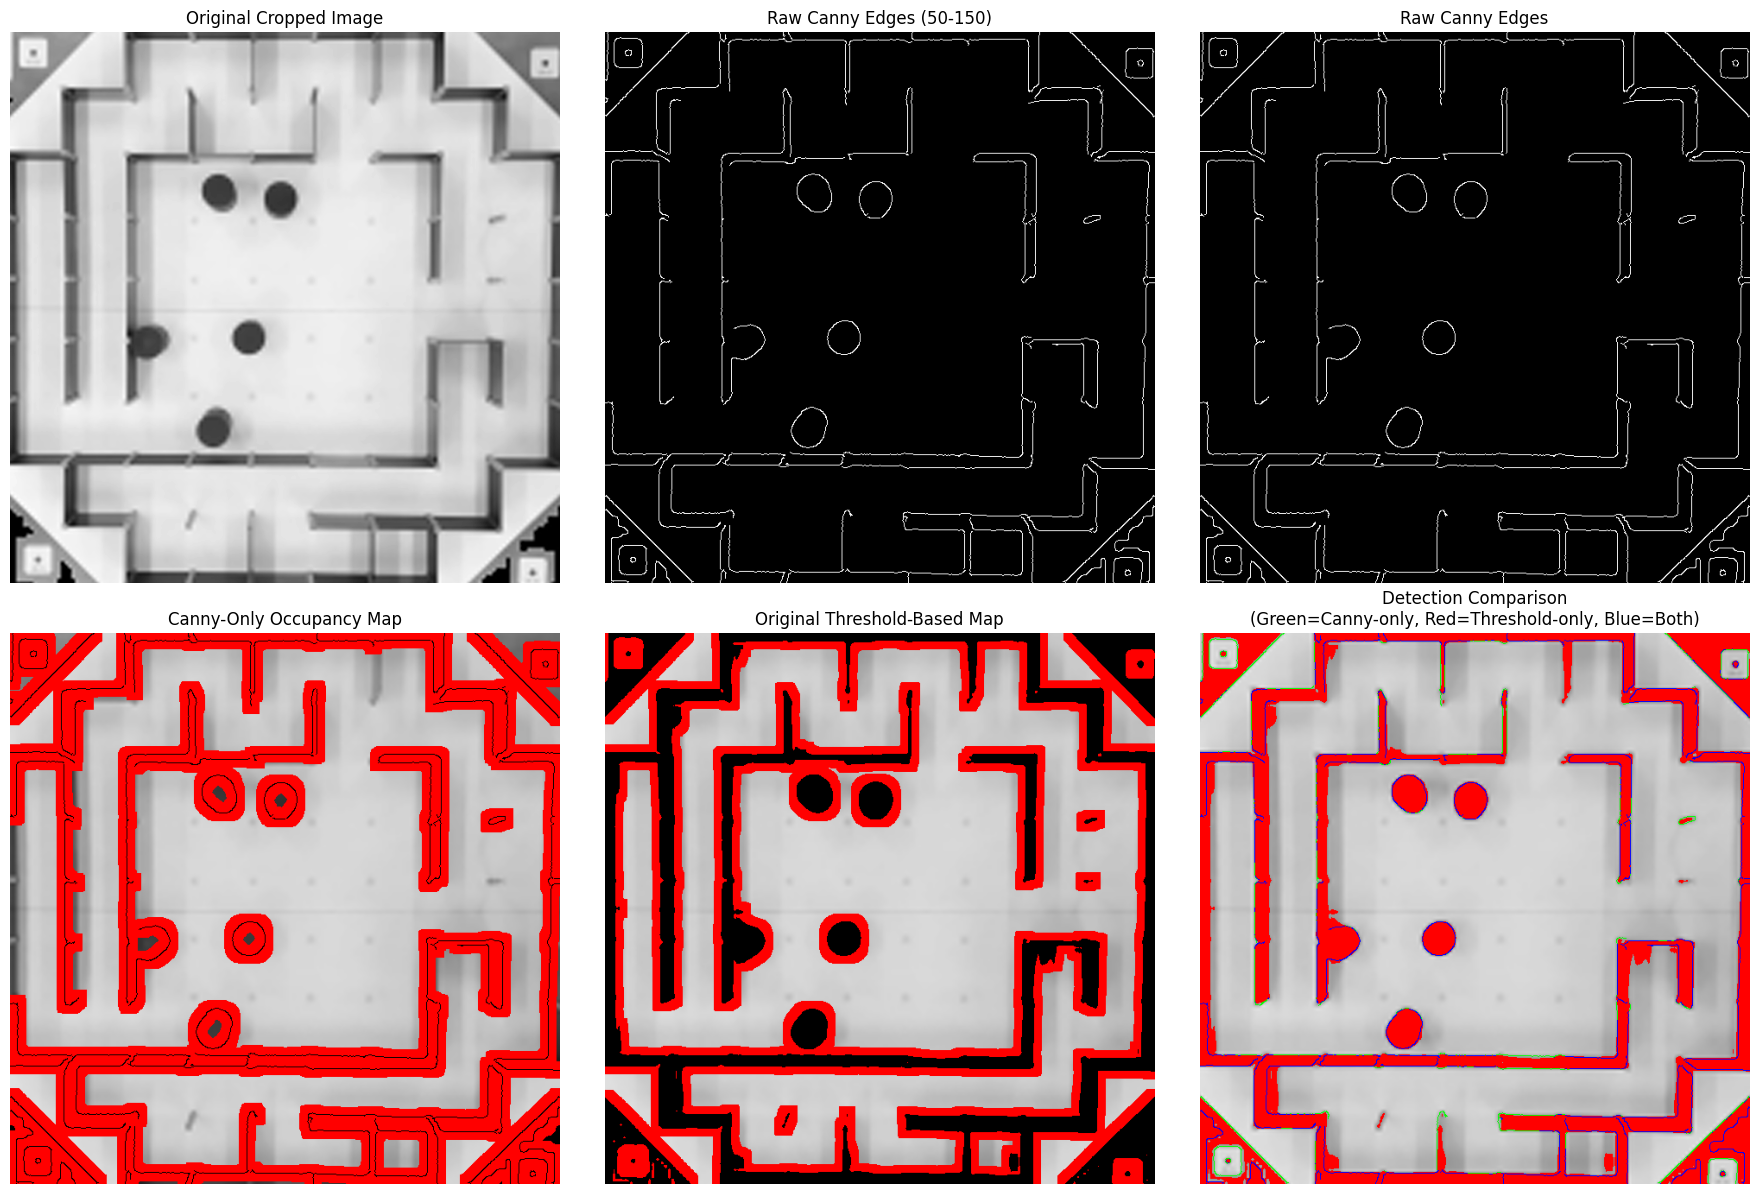

Raw Canny-Only vs Threshold Comparison:
  Canny thresholds: 50-150
  Original threshold value: 150
  Raw Canny obstacles: 10109 pixels
  Threshold-only obstacles: 86447 pixels
  Canny-only detections: 2991 pixels
  Threshold-only detections: 79329 pixels
  Both methods detect: 7118 pixels


In [7]:
# Task 1.3 - Canny-Only Edge Detection for Occupancy Map
# Using ONLY Canny edges for obstacle detection (no threshold or Sobel)

# Apply Gaussian blur to reduce noise before edge detection
blurred = cv2.GaussianBlur(cropped, (5, 5), 0)

# Canny Edge Detection - using only this for obstacle detection
canny_edges = cv2.Canny(blurred, canny_low_threshold, canny_high_threshold)

# Create configuration space (expand obstacles) using raw Canny edges (no cleaning)
kernel = np.ones((unsafe_kernel_size, unsafe_kernel_size), np.uint8)
expanded_canny = cv2.dilate(canny_edges, kernel, iterations=unsafe_iterations)
canny_buffer = expanded_canny - canny_edges

# For comparison, also create the original threshold-based occupancy map
_, original_binary = cv2.threshold(cropped, threshold_value, 255, cv2.THRESH_BINARY_INV)
expanded_original = cv2.dilate(original_binary, kernel, iterations=unsafe_iterations)
original_buffer = expanded_original - original_binary

# Create visualization comparing Canny-only vs Original threshold approach
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Original cropped image
axes[0,0].imshow(cropped, cmap='gray')
axes[0,0].set_title('Original Cropped Image')
axes[0,0].axis('off')

# Raw Canny edges
axes[0,1].imshow(canny_edges, cmap='gray')
axes[0,1].set_title(f'Raw Canny Edges ({canny_low_threshold}-{canny_high_threshold})')
axes[0,1].axis('off')

# Raw Canny edges (no morphological operations)
axes[0,2].imshow(canny_edges, cmap='gray')
axes[0,2].set_title('Raw Canny Edges')
axes[0,2].axis('off')

# Canny-only occupancy map with configuration space
canny_viz = cv2.cvtColor(cropped, cv2.COLOR_GRAY2RGB)
canny_viz[canny_buffer == 255] = [255, 0, 0]  # Buffer zone in red
canny_viz[canny_edges == 255] = [0, 0, 0]   # Obstacles in black

axes[1,0].imshow(canny_viz)
axes[1,0].set_title('Canny-Only Occupancy Map')
axes[1,0].axis('off')

# Original threshold-based occupancy map for comparison
original_viz = cv2.cvtColor(cropped, cv2.COLOR_GRAY2RGB)
original_viz[original_buffer == 255] = [255, 0, 0]  # Buffer zone in red
original_viz[original_binary == 255] = [0, 0, 0]    # Obstacles in black

axes[1,1].imshow(original_viz)
axes[1,1].set_title('Original Threshold-Based Map')
axes[1,1].axis('off')

# Difference visualization (what Canny detects vs threshold)
diff_viz = cv2.cvtColor(cropped, cv2.COLOR_GRAY2RGB)
canny_only = cv2.bitwise_and(canny_edges, cv2.bitwise_not(original_binary))  # Edges not in threshold
threshold_only = cv2.bitwise_and(original_binary, cv2.bitwise_not(canny_edges))  # Threshold not in edges
both = cv2.bitwise_and(canny_edges, original_binary)  # Both methods detect

diff_viz[canny_only == 255] = [0, 255, 0]      # Green: Canny-only detections
diff_viz[threshold_only == 255] = [255, 0, 0]  # Red: Threshold-only detections  
diff_viz[both == 255] = [0, 0, 255]            # Blue: Both methods detect

axes[1,2].imshow(diff_viz)
axes[1,2].set_title('Detection Comparison\n(Green=Canny-only, Red=Threshold-only, Blue=Both)')
axes[1,2].axis('off')

plt.tight_layout()
plt.show()

print(f"Raw Canny-Only vs Threshold Comparison:")
print(f"  Canny thresholds: {canny_low_threshold}-{canny_high_threshold}")
print(f"  Original threshold value: {threshold_value}")
print(f"  Raw Canny obstacles: {np.sum(canny_edges == 255)} pixels")
print(f"  Threshold-only obstacles: {np.sum(original_binary == 255)} pixels")
print(f"  Canny-only detections: {np.sum(canny_only == 255)} pixels")
print(f"  Threshold-only detections: {np.sum(threshold_only == 255)} pixels")
print(f"  Both methods detect: {np.sum(both == 255)} pixels")

# Update the global processed image to use raw Canny-only approach
processed_image_canny = cropped.copy()
processed_image_canny[expanded_canny == 255] = 0


# Task 2 - Graph Class (0 marks total)

NOTE: This is slightly different to the graph in lab 07. x,y variables have been added to the node object.

In [8]:
# Task 2.1 (0 marks):  Complete the graph class

class Node:
    def __init__(self, node_id, x, y):
        self.id = node_id
        self.x = x
        self.y = y
    
    def get_point(self):
        return (self.x,self.y)
    
    def get_ID(self):
        return self.id

class Graph:
    def __init__(self):
        self.nodes = {}
        self.edges = {}

    def add_node(self, node_id, x, y):
        if node_id not in self.nodes:
            self.nodes[node_id] = Node(node_id, x, y)
            self.edges[node_id] = {}

    def add_edge(self, node_id1, node_id2, weight):
        if node_id1 in self.nodes and node_id2 in self.nodes:
            self.edges[node_id1][node_id2] = weight
            self.edges[node_id2][node_id1] = weight

    def remove_edge(self, node_id1, node_id2):
        if node_id1 in self.edges and node_id2 in self.edges[node_id1]:
            del self.edges[node_id1][node_id2]
        if node_id2 in self.edges and node_id1 in self.edges[node_id2]:
            del self.edges[node_id2][node_id1]
    
    def get_nodes(self):
        return list(self.nodes.values())
    
    def get_edge_weight(self, node_id1, node_id2):
        if node_id1 in self.edges and node_id2 in self.edges[node_id1]:
            return self.edges[node_id1][node_id2]
        return None


# Task 3 - BFS (10 marks total)

In [9]:
# This is a useful function that you may choose to implement and use 
# It looks through the image to see if the path is clear between one coordinate to the next
# Returns True or False 

# This is path_clear function has been created using A.I
def path_clear(check_image, x1, y1, x2, y2):
    # Use Bresenham's line algorithm to check all pixels along the path
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    x, y = x1, y1
    n = 1 + dx + dy
    x_inc = 1 if x2 > x1 else -1
    y_inc = 1 if y2 > y1 else -1
    error = dx - dy
    
    dx *= 2
    dy *= 2
    
    for _ in range(n):
        # Check coordinates are within image bounds
        if x < 0 or x >= check_image.shape[1] or y < 0 or y >= check_image.shape[0]:
            return False
        
        # Checks if pixel is an obstacle (assumes dark pixels are obstacles)
        if len(check_image.shape) == 3:  
            pixel_value = check_image[y, x, 0]  
        else: 
            pixel_value = check_image[y, x]
        
        if pixel_value < 127: 
            return False
        
        if error > 0:
            x += x_inc
            error -= dy
        else:
            y += y_inc
            error += dx
    
    return True

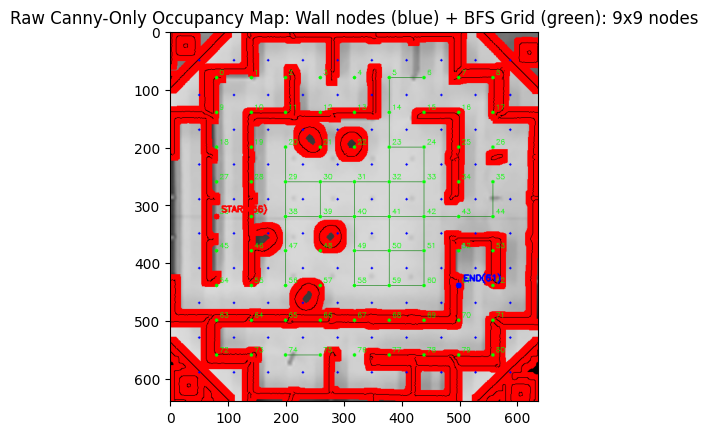

In [10]:
# Task 3.1 (5 marks): Generate a grid of nodes and connect the edges
# Use the cropped image from Task 1.2 instead of raw image
bfs_image = cv2.cvtColor(cropped, cv2.COLOR_GRAY2BGR)  # Convert cropped grayscale to BGR for visualization
bfs_graph = Graph()

# Use the Canny-only processed configuration space for path checking
# Use the Canny-based approach from Task 1.3
if 'processed_image_canny' in locals():
    processed_image = processed_image_canny
else:
    # Fallback: recreate raw Canny-based processed image
    blurred = cv2.GaussianBlur(cropped, (5, 5), 0)
    canny_edges = cv2.Canny(blurred, canny_low_threshold, canny_high_threshold)
    kernel = np.ones((unsafe_kernel_size, unsafe_kernel_size), np.uint8)
    expanded_canny = cv2.dilate(canny_edges, kernel, iterations=unsafe_iterations)
    processed_image = cropped.copy()
    processed_image[expanded_canny == 255] = 0 

# Generate dual grid system: wall-aligned grid (10x10) + centered BFS grid (9x9)
height, width = cropped.shape[:2]

# Define fixed margins from image boundaries
margin = 50  # margin to look similar to spec

# Calculate effective grid area (excluding margins)
effective_width = width - 2 * margin
effective_height = height - 2 * margin

# Create wall-aligned grid (10x10) - for visualization only
wall_grid_n = 10
wall_grid_spacing_x = effective_width / (wall_grid_n - 1) if wall_grid_n > 1 else 0
wall_grid_spacing_y = effective_height / (wall_grid_n - 1) if wall_grid_n > 1 else 0

wall_grid_nodes = []
for i in range(wall_grid_n):
    for j in range(wall_grid_n):
        x = margin + j * wall_grid_spacing_x  
        y = margin + i * wall_grid_spacing_y  
        wall_grid_nodes.append((int(round(x)), int(round(y))))

# Create centered BFS grid (9x9) - positioned at centers of wall grid squares
bfs_grid_n = 9
for i in range(bfs_grid_n):
    for j in range(bfs_grid_n):
        node_id = i * bfs_grid_n + j  # Convert 2D grid to 1D node ID
        
        # Calculate center position between wall grid squares
        center_x = margin + (j + 0.5) * wall_grid_spacing_x
        center_y = margin + (i + 0.5) * wall_grid_spacing_y
        
        bfs_graph.add_node(node_id, int(round(center_x)), int(round(center_y)))

######## Edge connection Logic is created with A.I - Updated for 9x9 BFS grid
for i in range(bfs_grid_n):
    for j in range(bfs_grid_n):
        current_id = i * bfs_grid_n + j
        current_node = bfs_graph.nodes[current_id]

        if j < bfs_grid_n - 1:
            right_id = i * bfs_grid_n + (j + 1)
            right_node = bfs_graph.nodes[right_id]
            if path_clear(processed_image, current_node.x, current_node.y, right_node.x, right_node.y):
                bfs_graph.add_edge(current_id, right_id, 1)  # Weight should be 1 as per specification
        
        if i < bfs_grid_n - 1:
            bottom_id = (i + 1) * bfs_grid_n + j
            bottom_node = bfs_graph.nodes[bottom_id]
            if path_clear(processed_image, current_node.x, current_node.y, bottom_node.x, bottom_node.y):
                bfs_graph.add_edge(current_id, bottom_id, 1)  # Weight should be 1 as per specification
################################

# Visualize both grids on the Canny-only occupancy map with configuration space
# Use raw Canny-based approach for visualization
if 'canny_buffer' in locals() and 'canny_edges' in locals():
    buffer_zone = canny_buffer
    obstacles = canny_edges
else:
    # Fallback: recreate if variables not available
    blurred = cv2.GaussianBlur(cropped, (5, 5), 0)
    obstacles = cv2.Canny(blurred, canny_low_threshold, canny_high_threshold)
    kernel = np.ones((unsafe_kernel_size, unsafe_kernel_size), np.uint8)
    expanded = cv2.dilate(obstacles, kernel, iterations=unsafe_iterations)
    buffer_zone = expanded - obstacles

bfs_image_copy = cv2.cvtColor(cropped, cv2.COLOR_GRAY2RGB)
bfs_image_copy[buffer_zone == 255] = [0, 0, 255]  # Convert buffer area to RED
bfs_image_copy[obstacles == 255] = [0, 0, 0]      # Obstacles in BLACK

# Draw wall-aligned grid (blue)
for i, (x, y) in enumerate(wall_grid_nodes):
    cv2.circle(bfs_image_copy, (x, y), 2, (255, 0, 0), -1)  # Blue circles, radius 2

# Drawing BFS grid edges (green)
for node_id in bfs_graph.nodes:
    node = bfs_graph.nodes[node_id]
    for connected_id in bfs_graph.edges[node_id]:
        # Only draw each edge once (avoid duplicates)
        if node_id < connected_id:
            connected_node = bfs_graph.nodes[connected_id]
            cv2.line(bfs_image_copy, (int(node.x), int(node.y)), 
                    (int(connected_node.x), int(connected_node.y)), (0, 125, 0), 1)  # Dark green, width 1

# Drawing BFS grid nodes (green)
for node in bfs_graph.get_nodes():
    cv2.circle(bfs_image_copy, (int(node.x), int(node.y)), 3, (0, 255, 0), -1)  # Light green, radius 3

# Label every BFS grid node (0, 1, 2, etc.)
for node_id, node in bfs_graph.nodes.items():
    # Use smaller font for all node labels
    cv2.putText(bfs_image_copy, str(node_id), (int(node.x) + 5, int(node.y) - 5), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)

# Highlight start and end nodes with special colors/sizes
start_node = bfs_graph.nodes[bfs_start_node]
end_node = bfs_graph.nodes[bfs_end_node]

# Draw larger circles for start (red) and end (blue) nodes
cv2.circle(bfs_image_copy, (int(start_node.x), int(start_node.y)), 5, (0, 0, 255), -1)  # Red start
cv2.circle(bfs_image_copy, (int(end_node.x), int(end_node.y)), 5, (255, 0, 0), -1)    # Blue end

# Add bigger labels for start and end nodes
cv2.putText(bfs_image_copy, f"START({bfs_start_node})", (int(start_node.x) + 8, int(start_node.y) - 8), 
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
cv2.putText(bfs_image_copy, f"END({bfs_end_node})", (int(end_node.x) + 8, int(end_node.y) - 8), 
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# Display Image
plt.imshow(cv2.cvtColor(bfs_image_copy, cv2.COLOR_BGR2RGB))
plt.title(f"Raw Canny-Only Occupancy Map: Wall nodes (blue) + BFS Grid (green): {bfs_grid_n}x{bfs_grid_n} nodes")
plt.show()


In [11]:
# Task 3.2 (5 marks): Implement BFS

# Returns an array of nodes in order of which nodes are visited next.
# ie. [0, 10, 20, 30, 40, 50, 60, 70, 71, 72, 73, 74, 75, 76, 77, 78, 88, 98, 99]
def bfs(graph, start_node_id, end_node_id):
    from collections import deque
    
    # Initialize BFS data structures
    queue = deque([start_node_id])
    visited = set([start_node_id])
    parent = {start_node_id: None}
    
    # BFS exploration
    while queue:
        current_node_id = queue.popleft()
        if current_node_id == end_node_id:
            break
        for neighbor_id in graph.edges[current_node_id]:
            if neighbor_id not in visited:
                visited.add(neighbor_id)
                parent[neighbor_id] = current_node_id
                queue.append(neighbor_id)
    
    # Reconstruct path from start to end
    path = []
    if end_node_id in parent: 
        current = end_node_id
        while current is not None:
            path.append(current)
            current = parent[current]
        path.reverse()  # Reverse to get path from start to end
    
    return path

Path: []
Path length: 0 nodes


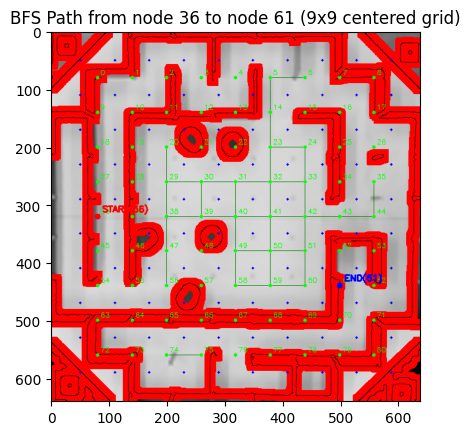

In [12]:
# Task 3.2: Implement BFS continued

# Run BFS and display the output
path = bfs(bfs_graph, bfs_start_node, bfs_end_node)

# Display the resulting path
print(f"Path: {path}")
print(f"Path length: {len(path)} nodes")

# Visualize the path on the grid
bfs_path_image = bfs_image_copy.copy()

# Drawing the path 
if len(path) > 1:
    for i in range(len(path) - 1):
        current_node = bfs_graph.nodes[path[i]]
        next_node = bfs_graph.nodes[path[i + 1]]
        cv2.line(bfs_path_image, 
                (int(current_node.x), int(current_node.y)), 
                (int(next_node.x), int(next_node.y)), 
                (255, 0, 0), 3)  # Blue as spec, width 3

start_node = bfs_graph.nodes[bfs_start_node]
end_node = bfs_graph.nodes[bfs_end_node]

# Display the image with path
plt.imshow(cv2.cvtColor(bfs_path_image, cv2.COLOR_BGR2RGB))
plt.title(f"BFS Path from node {bfs_start_node} to node {bfs_end_node} (9x9 centered grid)")
plt.show()

In [13]:
# Task 3.3 - Robot Movement Commands
# Convert BFS path to robot movement commands (L=left turn, F=forward, R=right turn)

def generate_robot_commands(graph, path):
    """
    Generate robot movement commands from a path of node IDs.
    
    Robot starts facing towards the first movement direction.
    Commands: L = rotate 90° counterclockwise, R = rotate 90° clockwise, F = move forward
    """
    if len(path) < 2:
        return "", []  # No movement needed
    
    # Define direction vectors (dx, dy) and their names
    directions = {
        (1, 0): "EAST",    # Right
        (-1, 0): "WEST",   # Left  
        (0, 1): "SOUTH",   # Down
        (0, -1): "NORTH"   # Up
    }
    
    # Direction transitions for 90-degree rotations
    # From current direction, what's left/right?
    direction_map = {
        (1, 0):  {"left": (0, -1), "right": (0, 1)},   # EAST: left=NORTH, right=SOUTH
        (-1, 0): {"left": (0, 1), "right": (0, -1)},   # WEST: left=SOUTH, right=NORTH  
        (0, 1):  {"left": (1, 0), "right": (-1, 0)},   # SOUTH: left=EAST, right=WEST
        (0, -1): {"left": (-1, 0), "right": (1, 0)}    # NORTH: left=WEST, right=EAST
    }
    
    commands = []
    command_string = ""
    directions_taken = []
    
    # Calculate all movement directions
    for i in range(len(path) - 1):
        current_node = graph.nodes[path[i]]
        next_node = graph.nodes[path[i + 1]]
        
        # Calculate direction vector (normalize to unit direction)
        dx = next_node.x - current_node.x
        dy = next_node.y - current_node.y
        
        # Normalize to unit directions (1, 0, -1)
        if dx > 0:
            dx = 1
        elif dx < 0:
            dx = -1
        if dy > 0:
            dy = 1
        elif dy < 0:
            dy = -1
            
        move_direction = (dx, dy)
        directions_taken.append(move_direction)
    
    # Robot starts facing the first movement direction
    current_facing = directions_taken[0]
    commands.append(f"F")  # First move is always forward
    command_string += "F"
    
    # Process remaining movements
    for i in range(1, len(directions_taken)):
        target_direction = directions_taken[i]
        
        if target_direction == current_facing:
            # Same direction - move forward
            commands.append("F")
            command_string += "F"
        elif target_direction == direction_map[current_facing]["left"]:
            # Need to turn left
            commands.append("L")
            commands.append("F")
            command_string += "LF"
            current_facing = target_direction
        elif target_direction == direction_map[current_facing]["right"]:
            # Need to turn right
            commands.append("R")
            commands.append("F") 
            command_string += "RF"
            current_facing = target_direction
        else:
            # 180-degree turn (turn around) - use two right turns
            commands.append("R")
            commands.append("R")
            commands.append("F")
            command_string += "RRF"
            current_facing = target_direction
    
    # Final step: Orient robot to face true north (0, -1) after reaching destination
    true_north = (0, -1)
    if current_facing != true_north:
        # Calculate how many right turns needed to face north
        if current_facing == (1, 0):      # EAST -> need 1 right turn to face NORTH
            commands.append("R")
            command_string += "R"
        elif current_facing == (0, 1):    # SOUTH -> need 2 right turns to face NORTH  
            commands.append("R")
            commands.append("R")
            command_string += "RR"
        elif current_facing == (-1, 0):   # WEST -> need 3 right turns (or 1 left) to face NORTH
            commands.append("L")  # More efficient than RRR
            command_string += "L"
        # If already facing north (0, -1), no additional turn needed
    
    return command_string, commands

# Generate robot commands from BFS path
if 'path' in locals() and len(path) > 1:
    robot_commands, command_list = generate_robot_commands(bfs_graph, path)
    
    print("🤖 ROBOT MOVEMENT COMMANDS")
    print("=" * 50)
    print(f"Path: {path}")
    print(f"Commands: {robot_commands}")
    print(f"Total moves: {len([c for c in robot_commands if c == 'F'])}")
    print(f"Total turns: {len([c for c in robot_commands if c in 'LR'])}")
    print(f"Command breakdown: {' '.join(command_list)}")
    print(f"Final orientation: NORTH (Robot ends facing true north ⬆️)")
    
    # Create visualization showing robot path with direction arrows
    robot_viz = bfs_path_image.copy()
    
    # Draw direction arrows on the path
    if len(path) > 1:
        for i in range(len(path) - 1):
            current_node = bfs_graph.nodes[path[i]]
            next_node = bfs_graph.nodes[path[i + 1]]
            
            # Calculate arrow direction
            dx = next_node.x - current_node.x
            dy = next_node.y - current_node.y
            
            # Draw arrow from current to next
            start_point = (int(current_node.x), int(current_node.y))
            end_point = (int(next_node.x), int(next_node.y))
            
            # Draw thicker arrow line
            cv2.arrowedLine(robot_viz, start_point, end_point, (255, 255, 0), 2, tipLength=0.3)
            
            # Add step number
            mid_x = int((current_node.x + next_node.x) / 2)
            mid_y = int((current_node.y + next_node.y) / 2)
            cv2.putText(robot_viz, str(i+1), (mid_x - 10, mid_y - 10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 0), 1)
    
    # Display robot path visualization
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(robot_viz, cv2.COLOR_BGR2RGB))
    plt.title(f"Robot Path with Movement Commands: {robot_commands}")
    plt.axis('off')
    plt.show()
    
    # Show detailed step-by-step breakdown
    print("\n📋 STEP-BY-STEP ROBOT MOVEMENTS:")
    print("-" * 50)
    print("Step | Node | Command | Description")
    print("-" * 50)
    
    cmd_index = 0
    for i, node_id in enumerate(path):
        if i == 0:
            print(f"  0  |  {node_id:2d}  |    -    | Starting position")
        else:
            if cmd_index < len(command_list):
                cmd = command_list[cmd_index]
                if cmd == "F":
                    print(f" {i:2d}  |  {node_id:2d}  |    F    | Move forward to node {node_id}")
                    cmd_index += 1
                elif cmd == "L":
                    print(f"     |     |    L    | Turn left (90° counterclockwise)")
                    cmd_index += 1
                    if cmd_index < len(command_list) and command_list[cmd_index] == "F":
                        print(f" {i:2d}  |  {node_id:2d}  |    F    | Move forward to node {node_id}")
                        cmd_index += 1
                elif cmd == "R":
                    print(f"     |     |    R    | Turn right (90° clockwise)")
                    cmd_index += 1
                    if cmd_index < len(command_list) and command_list[cmd_index] == "F":
                        print(f" {i:2d}  |  {node_id:2d}  |    F    | Move forward to node {node_id}")
                        cmd_index += 1
    
    # Show any remaining commands (final orientation to north)
    while cmd_index < len(command_list):
        cmd = command_list[cmd_index]
        if cmd == "L":
            print(f"     |     |    L    | Final turn: Face NORTH (true north orientation)")
        elif cmd == "R":
            print(f"     |     |    R    | Final turn: Face NORTH (true north orientation)")
        cmd_index += 1
    
else:
    print("❌ No valid BFS path found. Cannot generate robot commands.")
    robot_commands = ""


❌ No valid BFS path found. Cannot generate robot commands.


# Task 4 -  PRM and Dijkstra Algorithm (6 marks total)

In [14]:
# This is a useful function that you may choose to implement and use 
# It finds and returns the closest nodes that are within the range
# not really used for this function
def find_closest_nodes(image,graph, target_x, target_y,range):

    distances = []

    return distances[:n]


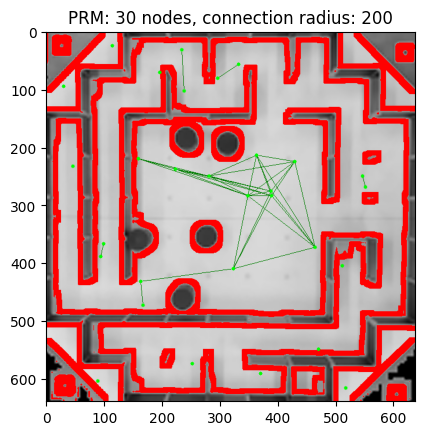

Successfully placed 30 valid nodes
Total edges created: 37


In [15]:
# Task 4.1 (3 marks): PRM
# NOTE: The iteration only increases when a valid node is placed on the map. If the node is invalid, the program should continue without incrementing the node count. 

# Use the cropped image from Task 1.2 instead of raw image
prm_image = cv2.cvtColor(cropped, cv2.COLOR_GRAY2BGR)  # Convert cropped grayscale to BGR for visualization
prm_graph = Graph()
random.seed(seed)

# Use the processed configuration space for obstacle checking
# Re-create the processed image from Task 1.2 using the cropped image
kernel = np.ones((unsafe_kernel_size, unsafe_kernel_size), np.uint8)

_, binary_obstacles = cv2.threshold(cropped, threshold_value, 255, cv2.THRESH_BINARY_INV)
expanded_obstacles = cv2.dilate(binary_obstacles, kernel, iterations=unsafe_iterations)

# Create processed image for collision checking
processed_image = cropped.copy()
processed_image[expanded_obstacles == 255] = 0  

i = 0
node_positions = [] 

while i < prm_total_nodes_count:
    # Generate random coordinates using cropped image dimensions
    # this issue with node position is fixed with the help from Mark Taranellos's advice on Ed 
    x = random.randint(0, cropped.shape[1]-1)  # x = width coordinate (columns)
    y = random.randint(0, cropped.shape[0]-1)  # y = height coordinate (rows)
    
    # Check if the position is valid (not in obstacle or expanded obstacle area)
    if processed_image[y, x] >= 127:  
        prm_graph.add_node(i, x, y)
        node_positions.append((i, x, y))
        i += 1 

# Connect nodes within connection radius if path is clear
for idx1, (id1, x1, y1) in enumerate(node_positions):
    for idx2, (id2, x2, y2) in enumerate(node_positions):
        if idx1 < idx2:
            distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            if distance <= prm_connection_radius:
                if path_clear(processed_image, x1, y1, x2, y2):
                    prm_graph.add_edge(id1, id2, distance)

# Create visualization with configuration space
buffer_zone = expanded_obstacles - binary_obstacles
prm_image_copy = cv2.cvtColor(cropped, cv2.COLOR_GRAY2RGB)
prm_image_copy[buffer_zone == 255] = [0, 0, 255] 

# Drawing edges
for node_id in prm_graph.nodes:
    node = prm_graph.nodes[node_id]
    for connected_id in prm_graph.edges[node_id]:
        if (node_id < connected_id) or (node_id < 0 and connected_id >= 0):
            connected_node = prm_graph.nodes[connected_id]
            cv2.line(prm_image_copy, (int(node.x), int(node.y)), 
                    (int(connected_node.x), int(connected_node.y)), (0, 125, 0), 1)  # Dark green, width 1

# Drawing nodes 
for node in prm_graph.get_nodes():
    cv2.circle(prm_image_copy, (int(node.x), int(node.y)), 3, (0, 255, 0), -1)  # Light green, radius 3

# Display image
plt.imshow(cv2.cvtColor(prm_image_copy, cv2.COLOR_BGR2RGB))
plt.title(f"PRM: {prm_total_nodes_count} nodes, connection radius: {prm_connection_radius}")
plt.show()

print(f"Successfully placed {len(prm_graph.nodes)} valid nodes")
print(f"Total edges created: {sum(len(edges) for edges in prm_graph.edges.values()) // 2}")  # Divide by 2 since edges are bidirectional

In [16]:
# Task 4.2 (3 marks): Dijkstra
# Example output - Path: [-1, 143, 43, 1, 14, 44, 67, 7, 9, 4, 12, 364, -2], Cost: 561.9189671797234

# Implemented this function using A.I
def dijkstra(graph, start_id, end_id):
    import heapq
    
    # Initialize distances and previous nodes
    distances = {node_id: float('inf') for node_id in graph.nodes}
    distances[start_id] = 0
    previous = {node_id: None for node_id in graph.nodes}
    
    # Priority queue: (distance, node_id)
    pq = [(0, start_id)]
    visited = set()
    
    while pq:
        current_distance, current_id = heapq.heappop(pq)
        if current_id in visited:
            continue
        visited.add(current_id)
        if current_id == end_id:
            break
        for neighbor_id in graph.edges[current_id]:
            if neighbor_id not in visited:
                # Get edge weight (distance between nodes)
                neighbor_weight = graph.edges[current_id][neighbor_id]
                new_distance = current_distance + neighbor_weight
                
                # Update if we found a shorter path
                if new_distance < distances[neighbor_id]:
                    distances[neighbor_id] = new_distance
                    previous[neighbor_id] = current_id
                    heapq.heappush(pq, (new_distance, neighbor_id))
    
    # Reconstruct path
    path = []
    current = end_id
    
    # Check if path exists
    if distances[end_id] == float('inf'):
        return ([], 0)
    
    # Build path backwards from end to start
    while current is not None:
        path.append(current)
        current = previous[current]
    
    # Reverse to get path from start to end
    path.reverse()
    
    total_cost = distances[end_id]
    return (path, total_cost)

Using grid node 20 as start: (199, 200)
Using grid node 60 as goal: (438, 439)
Cropped image dimensions: 637x639
Start location: (199, 200)
Goal location: (438, 439)
Start location valid: True
Goal location valid: True
Start node connected to 4 nodes
Goal node connected to 5 nodes
Path: [-1, 8, -2], Cost: 350.28


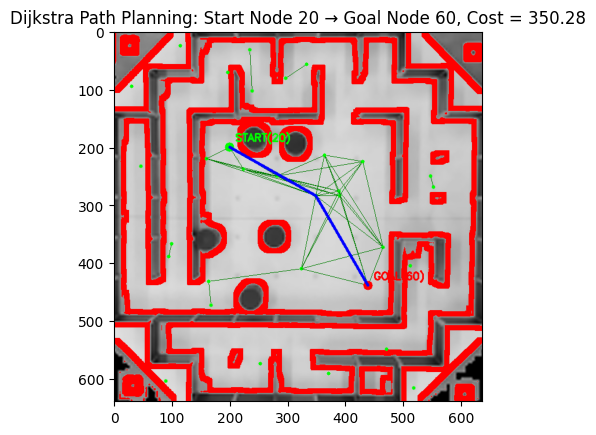

In [17]:
# Task 4.2: Dijkstra continued

# Ensure processed_image is available for path checking
# (should already be defined from Task 4.1, but define here as backup since first time using jupyter & cells)
if 'processed_image' not in locals():
    kernel = np.ones((unsafe_kernel_size, unsafe_kernel_size), np.uint8)
    _, binary_obstacles = cv2.threshold(cropped, threshold_value, 255, cv2.THRESH_BINARY_INV)
    expanded_obstacles = cv2.dilate(binary_obstacles, kernel, iterations=unsafe_iterations)
    processed_image = cropped.copy()
    processed_image[expanded_obstacles == 255] = 0

# Convert grid node numbers to pixel coordinates using same system as BFS
def grid_node_to_coordinates(node_id, image_width, image_height):
    """Convert BFS grid node ID (0-80) to pixel coordinates using same grid system as BFS"""
    # Use same grid calculation as BFS (9x9 grid)
    bfs_grid_n = 9
    margin = 50  # Same margin as BFS
    
    # Calculate effective grid area
    effective_width = image_width - 2 * margin
    effective_height = image_height - 2 * margin
    
    # Calculate grid spacing (wall-aligned grid for reference)
    wall_grid_spacing_x = effective_width / (10 - 1) if 10 > 1 else 0
    wall_grid_spacing_y = effective_height / (10 - 1) if 10 > 1 else 0
    
    # Convert node ID to grid position
    i = node_id // bfs_grid_n  # row
    j = node_id % bfs_grid_n   # column
    
    # Calculate center position (same as BFS grid positioning)
    center_x = margin + (j + 0.5) * wall_grid_spacing_x
    center_y = margin + (i + 0.5) * wall_grid_spacing_y
    
    return int(round(center_x)), int(round(center_y))

# Convert start and end node numbers to coordinates
height, width = cropped.shape[:2]
start_x, start_y = grid_node_to_coordinates(prm_start_node, width, height)
goal_x, goal_y = grid_node_to_coordinates(prm_end_node, width, height)

print(f"Using grid node {prm_start_node} as start: ({start_x}, {start_y})")
print(f"Using grid node {prm_end_node} as goal: ({goal_x}, {goal_y})")

# Validate start/goal locations are within image bounds and not in obstacles
height, width = processed_image.shape[:2]
print(f"Cropped image dimensions: {width}x{height}")
print(f"Start location: ({start_x}, {start_y})")
print(f"Goal location: ({goal_x}, {goal_y})")

# Check bounds and obstacle status
start_valid = (0 <= start_x < width and 0 <= start_y < height and processed_image[start_y, start_x] >= 127)
goal_valid = (0 <= goal_x < width and 0 <= goal_y < height and processed_image[goal_y, goal_x] >= 127)

print(f"Start location valid: {start_valid}")
print(f"Goal location valid: {goal_valid}")

if not start_valid:
    print("WARNING: Start location is invalid (out of bounds or in obstacle)")
if not goal_valid:
    print("WARNING: Goal location is invalid (out of bounds or in obstacle)")

# Add special start and goal nodes with IDs -1 and -2
prm_graph.add_node(-1, start_x, start_y)
prm_graph.add_node(-2, goal_x, goal_y)

# Connect start and end nodes to the existing PRM graph
start_connections = 0
goal_connections = 0

# Connect start node (-1) to nearby nodes
for node_id, node in prm_graph.nodes.items():
    if node_id not in [-1, -2]:  # Don't connect to itself or goal
        distance = math.sqrt((node.x - start_x)**2 + (node.y - start_y)**2)
        if distance <= prm_connection_radius:
            if path_clear(processed_image, start_x, start_y, node.x, node.y):
                prm_graph.add_edge(-1, node_id, distance)
                start_connections += 1

# Connect goal node (-2) to nearby nodes  
for node_id, node in prm_graph.nodes.items():
    if node_id not in [-1, -2]:  # Don't connect to itself or start
        distance = math.sqrt((node.x - goal_x)**2 + (node.y - goal_y)**2)
        if distance <= prm_connection_radius:
            if path_clear(processed_image, goal_x, goal_y, node.x, node.y):
                prm_graph.add_edge(-2, node_id, distance)
                goal_connections += 1

# Find shortest path using Dijkstra
path, cost = dijkstra(prm_graph, -1, -2)

print(f"Start node connected to {start_connections} nodes")
print(f"Goal node connected to {goal_connections} nodes")
print(f"Path: {path}, Cost: {cost:.2f}")

# Create visualisation
dijkstra_image = prm_image_copy.copy()

# Draw edges for start/goal nodes (since they were added after prm_image_copy was created)
for node_id in [-1, -2]:  # Only draw edges for start and goal nodes
    if node_id in prm_graph.nodes:
        node = prm_graph.nodes[node_id]
        for connected_id in prm_graph.edges[node_id]:
            connected_node = prm_graph.nodes[connected_id]
            cv2.line(dijkstra_image, (int(node.x), int(node.y)), 
                    (int(connected_node.x), int(connected_node.y)), (0, 125, 0), 1)  # Dark green, width 1

# Highlight start and goal nodes
start_node = prm_graph.nodes[-1]
goal_node = prm_graph.nodes[-2]
cv2.circle(dijkstra_image, (int(start_node.x), int(start_node.y)), 8, (0, 255, 0), -1)  # Green start
cv2.circle(dijkstra_image, (int(goal_node.x), int(goal_node.y)), 8, (0, 0, 255), -1)   # Red goal

# Add labels with grid node numbers
cv2.putText(dijkstra_image, f"START({prm_start_node})", (int(start_node.x) + 10, int(start_node.y) - 10), 
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
cv2.putText(dijkstra_image, f"GOAL({prm_end_node})", (int(goal_node.x) + 10, int(goal_node.y) - 10), 
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

# Draw the path if one exists
if len(path) > 1:
    for i in range(len(path) - 1):
        current_node = prm_graph.nodes[path[i]]
        next_node = prm_graph.nodes[path[i + 1]]
        cv2.line(dijkstra_image, 
                (int(current_node.x), int(current_node.y)),
                (int(next_node.x), int(next_node.y)),
                (255, 0, 0), 3)  # blue, width 3
else:
    print("WARNING: No path found between start and goal!")

# Display the resulting image (convert from BGR to RGB for proper display)
plt.imshow(cv2.cvtColor(dijkstra_image, cv2.COLOR_BGR2RGB))
plt.title(f"Dijkstra Path Planning: Start Node {prm_start_node} → Goal Node {prm_end_node}, Cost = {cost:.2f}")
plt.show()


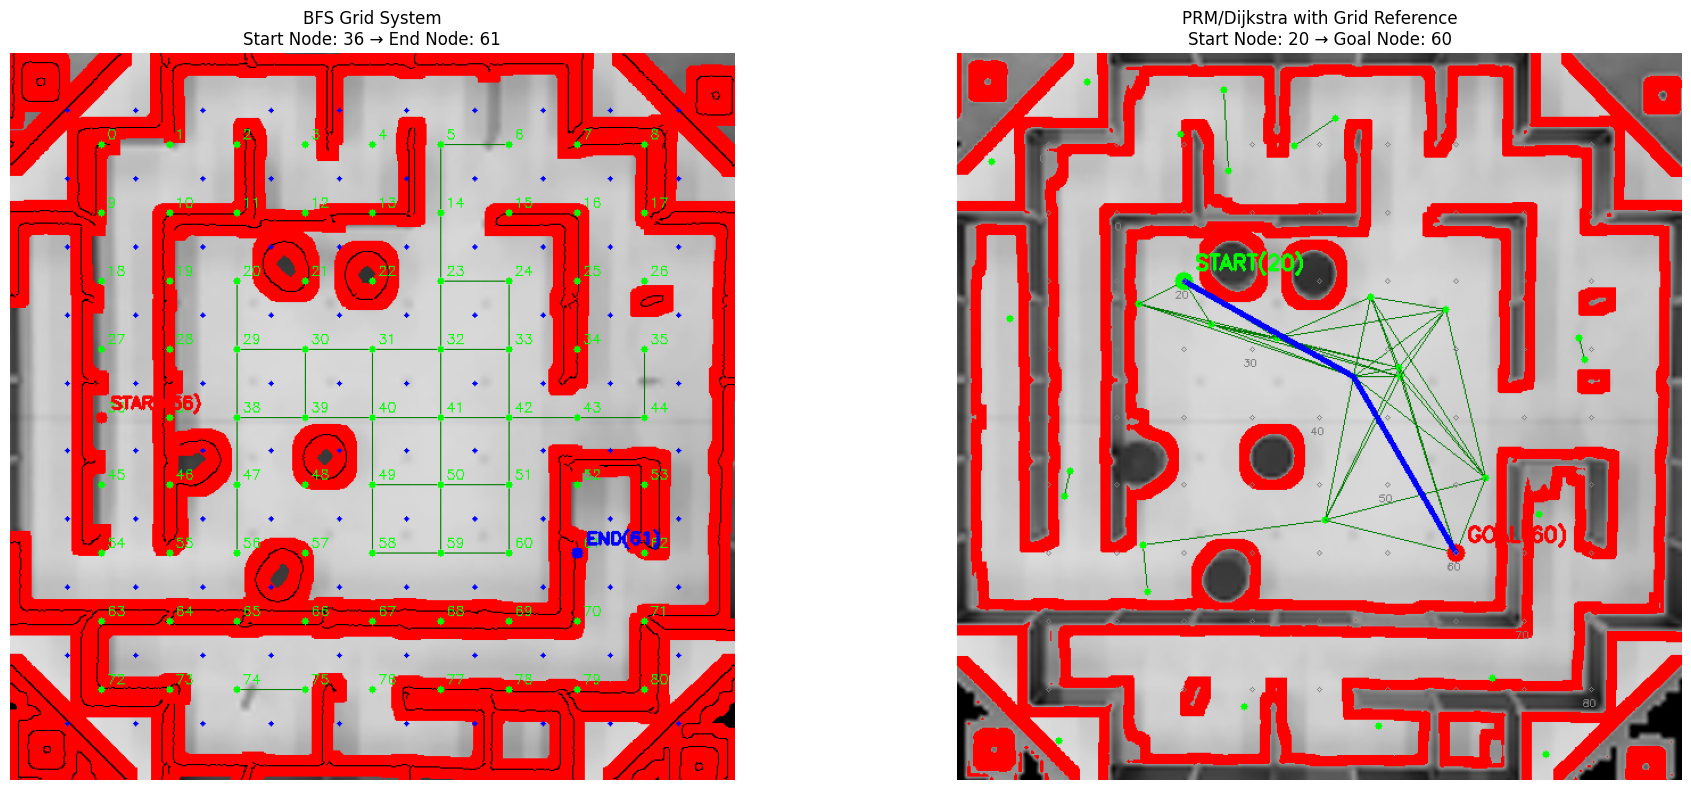

✅ GRID NODE REFERENCING COMPARISON
BFS Algorithm:
  Start Node: 36 → End Node: 61
  Uses 9x9 grid system (nodes 0-80)

PRM/Dijkstra Algorithm:
  Start Node: 20 → Goal Node: 60
  Now uses SAME 9x9 grid system (nodes 0-80)
  Start coordinates: (199, 200)
  Goal coordinates: (438, 439)

🔄 Both algorithms now use identical grid/node number referencing!


In [18]:
# Grid Node Referencing Comparison: BFS vs PRM/Dijkstra
# Show that both algorithms now use the same grid/node number referencing system

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Left: BFS Grid with highlighted start/end nodes
bfs_comparison = bfs_image_copy.copy()
axes[0].imshow(cv2.cvtColor(bfs_comparison, cv2.COLOR_BGR2RGB))
axes[0].set_title(f"BFS Grid System\nStart Node: {bfs_start_node} → End Node: {bfs_end_node}")
axes[0].axis('off')

# Right: PRM with BFS grid overlay to show same referencing
prm_comparison = dijkstra_image.copy()

# Overlay BFS grid nodes on PRM visualization to show same referencing system
for node_id, node in bfs_graph.nodes.items():
    # Draw smaller BFS grid nodes as reference points
    cv2.circle(prm_comparison, (int(node.x), int(node.y)), 2, (128, 128, 128), 1)  # Gray circles
    # Label key nodes for reference
    if node_id in [prm_start_node, prm_end_node] or node_id % 10 == 0:
        cv2.putText(prm_comparison, str(node_id), (int(node.x) - 8, int(node.y) + 15), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.3, (128, 128, 128), 1)

axes[1].imshow(cv2.cvtColor(prm_comparison, cv2.COLOR_BGR2RGB))
axes[1].set_title(f"PRM/Dijkstra with Grid Reference\nStart Node: {prm_start_node} → Goal Node: {prm_end_node}")
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("✅ GRID NODE REFERENCING COMPARISON")
print("=" * 50)
print(f"BFS Algorithm:")
print(f"  Start Node: {bfs_start_node} → End Node: {bfs_end_node}")
print(f"  Uses 9x9 grid system (nodes 0-80)")
print(f"")
print(f"PRM/Dijkstra Algorithm:")
print(f"  Start Node: {prm_start_node} → Goal Node: {prm_end_node}")
print(f"  Now uses SAME 9x9 grid system (nodes 0-80)")
print(f"  Start coordinates: ({start_x}, {start_y})")
print(f"  Goal coordinates: ({goal_x}, {goal_y})")
print(f"")
print("🔄 Both algorithms now use identical grid/node number referencing!")


# Task 5 - Rapidly-exploring random trees (RRT) (4 marks total)

In [19]:
# This is a useful function which you may choose to impliment and use 
# Given a random point it extends the tree by either the step distance or the cartesian distance
def calculate_new_tree_point( x_closest, y_closest, x, y,step):
    dx = y - y_closest
    dy = x - x_closest
    dist = math.sqrt(dx**2 + dy**2)
    if dist == 0:
        return x, y, 0
    if dist <= step:
        return x, y, dist
    ratio = step / dist
    new_x = x_closest + dy * ratio
    new_y = y_closest + dx * ratio
    return new_x, new_y, step
    

# This is a useful function which you may choose to impliment and use 
# It finds and returns the closest node to a point on the image
def find_closest_node_rrt(graph, target_x, target_y):
    min_dist = float('inf')
    closest_id = None
    for node_id, node in graph.nodes.items():
        dist = math.sqrt((node.y - target_x)**2 + (node.x - target_y)**2)
        if dist < min_dist:
            min_dist = dist
            closest_id = node_id
    return closest_id


In [ ]:
# Use the cropped image from Task 1.2 instead of raw image
rrt_image = cv2.cvtColor(cropped, cv2.COLOR_GRAY2BGR)  # Convert cropped grayscale to BGR for visualization
rrt_graph = Graph()
random.seed(seed)

# Create processed_image for collision checking using cropped image
kernel = np.ones((unsafe_kernel_size, unsafe_kernel_size), np.uint8)
_, binary_obstacles = cv2.threshold(cropped, threshold_value, 255, cv2.THRESH_BINARY_INV)

#expand obstacles 
expanded_obstacles = cv2.dilate(binary_obstacles, kernel, iterations=unsafe_iterations)
processed_image = cropped.copy()
processed_image[expanded_obstacles == 255] = 0

# Start and goal
start_col, start_row = rrt_start_location
goal_col, goal_row = rrt_goal_location

# Add start node
rrt_graph.add_node(-1, start_col, start_row)
parent = {-1: None}
cost = {-1: 0.0}

goal_added = False
i = 0
height, width = processed_image.shape


#grow the tree till reach goal or run out of tries
while i < rrt_max_nodes_count and not goal_added:
    rand_row = random.randint(0, height - 1)
    rand_col = random.randint(0, width - 1)
    
    closest_id = find_closest_node_rrt(rrt_graph, rand_row, rand_col)
    closest = rrt_graph.nodes[closest_id]
    
    new_row, new_col, dist_from_closest = calculate_new_tree_point(closest.y, closest.x, rand_row, rand_col, rrt_step_size)
    new_row_int = int(round(new_row))
    new_col_int = int(round(new_col))
    
    if processed_image[new_row_int, new_col_int] < 127:
        continue
    if not path_clear(processed_image, closest.x, closest.y, new_col_int, new_row_int):
        continue
    
    new_row = new_row_int
    new_col = new_col_int
    
    # Parent selection logic is partially A.I assisted 
    potential_parents = []
    for node_id, node in rrt_graph.nodes.items():
        dist_to_new = math.sqrt((node.x - new_col)**2 + (node.y - new_row)**2)
        if dist_to_new <= rrt_max_connection_length and path_clear(processed_image, node.x, node.y, new_col, new_row):
            potential_cost = cost[node_id] + dist_to_new
            potential_parents.append((potential_cost, node_id, dist_to_new))
    if not potential_parents:
        continue
# Pick cheapest parent
    potential_parents.sort()
    best_cost, best_parent_id, best_dist = potential_parents[0]
    new_id = i
    rrt_graph.add_node(new_id, new_col, new_row)
    rrt_graph.add_edge(best_parent_id, new_id, best_dist)
    parent[new_id] = best_parent_id
    cost[new_id] = best_cost

    # Rewiring Logic created using A.I
    # Rewiring neighbours if they’d be cheaper through the new point
    for p_cost, node_id, p_dist in potential_parents:
        if node_id == best_parent_id:
            continue
        new_cost = cost[new_id] + p_dist
        if new_cost < cost[node_id]:
            old_parent = parent[node_id]
            rrt_graph.remove_edge(old_parent, node_id)
            rrt_graph.add_edge(new_id, node_id, p_dist)
            parent[node_id] = new_id
            cost[node_id] = new_cost
    i += 1
    # Check if we can connect the goal from here
    dist_to_goal = math.sqrt((new_col - goal_col)**2 + (new_row - goal_row)**2)
    if dist_to_goal <= rrt_step_size and path_clear(processed_image, new_col, new_row, goal_col, goal_row):
        goal_id = -2
        rrt_graph.add_node(goal_id, goal_col, goal_row)
        rrt_graph.add_edge(new_id, goal_id, dist_to_goal)
        parent[goal_id] = new_id
        cost[goal_id] = cost[new_id] + dist_to_goal
        goal_added = True
        print(f"Goal reached after {i} nodes with total cost: {cost[goal_id]:.2f}")

        # Backtrack from goal to start to get the final path
if goal_added:
    path = []
    current = -2
    while current is not None:
        path.append(current)
        current = parent.get(current)
    path.reverse()
    print(f"Path found: {path}")
    print(f"Path cost: {cost[-2]:.2f}")
    print(f"Total nodes generated: {i}")

# Visualisation

buffer_zone = expanded_obstacles - binary_obstacles
rrt_image_copy = cv2.cvtColor(cropped, cv2.COLOR_GRAY2RGB)
rrt_image_copy[buffer_zone == 255] = [0, 0, 255]

# Drawing tree edges
for node_id in rrt_graph.nodes:
    for connected_id in rrt_graph.edges[node_id]:
        if node_id < connected_id:
            node = rrt_graph.nodes[node_id]
            conn = rrt_graph.nodes[connected_id]
            cv2.line(rrt_image_copy, (int(node.x), int(node.y)), (int(conn.x), int(conn.y)), (0, 125, 0), 1)

# Drawing nodes
for node in rrt_graph.get_nodes():
    cv2.circle(rrt_image_copy, (int(node.x), int(node.y)), 3, (0, 255, 0), -1)

# Highlight path
if goal_added:
    for j in range(len(path)-1):
        curr = rrt_graph.nodes[path[j]]
        nextn = rrt_graph.nodes[path[j+1]]
        cv2.line(rrt_image_copy, (int(curr.x), int(curr.y)), (int(nextn.x), int(nextn.y)), (255, 0, 0), 3)
    
plt.imshow(cv2.cvtColor(rrt_image_copy, cv2.COLOR_BGR2RGB))
plt.show()